In [2]:
import json
import pandas as pd
import time
import ccy 
from tqdm import tqdm_notebook as tqdm
import collections
from collections import Counter
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt

import operator

import urllib.request

In [3]:
from ripple_api import RippleDataAPIClient,RippleRPCClient
api = RippleDataAPIClient('https://data.ripple.com')
rpc = RippleRPCClient('http://s1.ripple.com:51234/')

# 0. Data

Read the data, run only once 

In [3]:
df = pd.read_csv("ripple-transactions-jan-2013-dec-2016.csv")

In [4]:
df.head()

,Unnamed: 0,hash,sender,receiver,currency,amount,ledger,sourceTag,DestinationTag,9,10
0,0,5C0504B229CD8EE803B01D78868B8F4B595D8B1D03636B...,rfe8yiZUymRPx35BEwGjhfkaLmgNsTytxT,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,XRP,0.1,7227428,NaN,NaN,1,1402920660
1,1,56022C64D29974C116591563DC8A80547907BE38EEB134...,rfe8yiZUymRPx35BEwGjhfkaLmgNsTytxT,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,XRP,0.1,7224947,NaN,NaN,1,1402908860
2,2,CCA2EB48BC106C7F4692BF71819EC236C9E09E37BCF38C...,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,rhjyoR8rpLMKM47pUgTjdNuVDJ1CrYYBwT,XRP,2000.0,5541569,NaN,NaN,1,1394924250
3,3,423708E30D94335FE2858C11B3D57390669A20FCE6C485...,rMTzGg7nPPEMJthjgEBfiPZGoAM7MEVa1r,rsdbFqwyGYX5fSvAmMEXBH2hRyBT8QfcUS,XRP,2020.0,3333190,NaN,NaN,1,1384463290
4,4,C1E342D3168740197C7E6B84110CEF9A338EA0D0EF5697...,rLz6TEYTsSZivwgXssq8ZSmTsBSFTMCw7h,rffqWVgnv9bPKaWHHVUDMjdAEgab3LGjZ1,XRP,100.0,6965416,NaN,NaN,1,1401681860


In [523]:
data = []
with open('more-txs-from-missing-parsed.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line))
with open('final_txs_2017.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line)) 

Try to recover some senderCurrency field that are missing. Getting currency of link with sender

In [524]:
ctr = 0
for index in tqdm(range(len(data))):
    txn = data[index]
    if 'senderCurrency' not in txn.keys() and 'links' in txn.keys() :
        sender = txn['sender']
        for link in txn['links']:
            if link['node1'] == sender or link['node2'] == sender:
                ctr +=1 
                txn['senderCurrency'] = link['currency']
print(ctr)                


21838


Uniform the data because we have fields 'actualReceiverCurrency' and 'receiverCurrency' so put them all under 'receiverCurrency'.

In [525]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'actualReceiverCurrency' in txn.keys() :
            txn['receiverCurrency'] = txn['actualReceiverCurrency']
            del txn['actualReceiverCurrency']
            

In [526]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'senderCurrency' not in txn.keys():
            txn['senderCurrency'] = txn['receiverCurrency']    

In [9]:
print(json.dumps(data[1],indent = 4))
print(json.dumps(data[7],indent = 4))

{
    "fee": 1e-05,
    "hash": "3F7A1B3A771D477B03104E86CE73790BB8C8E516BEE680BB4AD9893444D21CF3",
    "sender": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
    "success": "tesSUCCESS",
    "actualReceiverAmount": "0.000001",
    "XRPAcc": [
        {
            "isIncr": false,
            "account": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
            "amount": 1.100000000064938e-05
        },
        {
            "isIncr": true,
            "account": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
            "amount": 1.0000001111620804e-06
        }
    ],
    "flags": "",
    "receiver": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
    "date": "2013-06-29T13:10:20+00:00",
    "actualIssuerReceiver": "--",
    "receiverCurrency": "XRP",
    "senderCurrency": "XRP"
}
{
    "fee": 1.2e-05,
    "issuerReceiver": "--",
    "sender": "rQ9ArM8TdHmeQHvd969nQPP1TZosBhzdXg",
    "success": "tesSUCCESS",
    "paths": [
        [
            {
                "account": "ruazs5h1qEsqpke88pcqnaseXdm6od2xc"
         

# 1.Transactions

## 1.1 First hop

In [7]:
wallets_first_hop = collections.defaultdict(list)
for txn in tqdm(data):
    sender = txn["sender"]
    try:
        for link in txn["links"]:
            if link["node1"] == sender:
                wallets_first_hop[sender].append(link["node2"])
    except KeyError:
        continue 

In [8]:
wallet_two_most_hops = {}
count_unique_first_hop = 0
count_unique_first_hop_if_more_than_one_transaction = 0
for k in tqdm(list(wallets_first_hop.keys())):
    counter=collections.Counter(wallets_first_hop[k])
    wallet_two_most_hops[k] = counter.most_common(2)
    if(len(wallet_two_most_hops[k]) == 1):
        count_unique_first_hop += 1
        for a,b in wallet_two_most_hops[k]:
            if(b != 1):
                count_unique_first_hop_if_more_than_one_transaction += 1

In [9]:
print("There are " + str(count_unique_first_hop/len(wallet_two_most_hops)*100) + "% of wallets that uses always same first hop" +
      " and only " + str(count_unique_first_hop_if_more_than_one_transaction/len(wallet_two_most_hops)*100) + "% if we consider wallets that did more than 1 transaction")

There are 85.15420507567998% of wallets that uses always same first hop and only 40.51439626721292% if we consider wallets that did more than 1 transaction


In [10]:
first_hops = []
for k in tqdm(list(wallets_first_hop.keys())):
    for hop in list(set(wallets_first_hop[k])):
        if hop not in first_hops:
            first_hops.append(hop)

In [11]:
gateways = api.get_all_gateways()

In [12]:
gateways_wallet = []
for k in tqdm(list(gateways.keys())):
    for gateway in gateways[k]:
        gateways_wallet.append(gateway["account"])

In [13]:
inter = list(set(gateways_wallet) & set(first_hops))

In [14]:
print("From the first hops only "+ str(len(inter)/len(first_hops)*100) + "% are know gateways.")

From the first hops only 4.644412191582003% are know gateways.


## 1.2 No hops

In [22]:
all_senders = set()
sender_with_paths = set()
all_txn = set()
txn_with_paths = set()
for txn in tqdm(data):
    sender = txn["sender"]
    txn_hash = txn["hash"]
    all_senders.add(sender)
    all_txn.add(txn_hash)
    if "links" in txn.keys():
        sender_with_paths.add(sender)  
        txn_with_paths.add(txn_hash)

In [23]:
sender_with_only_two_hops = list(all_senders - sender_with_paths)
txn_with_only_two_hops = list(all_txn - txn_with_paths)

In [24]:
print("We have "+ str(len(sender_with_only_two_hops)/len(all_senders)*100) + "% of senders that never use paths")

We have 79.74224786535423% of senders that never use paths


In [25]:
print("We have "+ str(len(txn_with_only_two_hops)/len(all_txn)*100) + "% of transactions that never use paths")

We have 88.624591900084% of transactions that never use paths


## 1.3. Currency of direct transactions

In [84]:
currency_direct_txn_not_XRP = set()
count_direct_txn_not_XRP = 0
count_direct_txn_XRP = 0
for i in tqdm(range(len(data))):
    txn = data[i]
    if txn['success'] == 'tesSUCCESS':
        #direct
        if 'links' not in txn.keys():
            if 'senderCurrency' in txn.keys():
                if txn['senderCurrency'] != 'XRP':
                    currency_direct_txn_not_XRP.add(txn['senderCurrency'])
                    count_direct_txn_not_XRP += 1
            else:
                count_direct_txn_XRP += 1
        #direct (1 link) 
        else:
            if len(txn['links']) <= 1:
                if 'offers' not in txn.keys():
                    count_direct_txn_XRP += 1

In [85]:
print("There are", count_direct_txn_not_XRP/(count_direct_txn_not_XRP+count_direct_txn_XRP) * 100,"% of direct payments in other curencies that XRP")

There are 1.1378474165267674 % of direct payments in other curencies that XRP


In [86]:
gateways = api.get_all_gateways()
online_gateways = ['SnapSwap','Gatehub Fifth','Bitstamp','Payroutes','WisePass','The Rock Trading','RippleChina','DotPayco','Coinex','Ripple Fox','Lake BTC','Bitso','GBI','Gatehub','EXRP','BPG']
online_gateways_dict = collections.defaultdict(list)
for currency,list_gateways in tqdm(gateways.items()):
    for gateway in list_gateways:
        if gateway['name'] in online_gateways:
            online_gateways_dict[currency].append(gateway)

In [87]:
online_gateways_dict = dict(online_gateways_dict)

In [88]:
currency_direct_payments_not_offered_by_gateways = 0
real_currency_direct_payments_not_offered_by_gateways = 0
currency_direct_payments_not_offered_by_online_gateways = 0
real_currency_direct_payments_not_offered_by_online_gateways = 0
for currency in tqdm(currency_direct_txn_not_XRP):
    
    #all gateways
    if currency not in gateways.keys():
        currency_direct_payments_not_offered_by_gateways += 1
        if currency == ccy.currency(currency):
            real_currency_direct_payments_not_offered_by_gateways += 1

    #online gateways
    if currency not in online_gateways_dict.keys():
        currency_direct_payments_not_offered_by_online_gateways += 1
        if currency == ccy.currency(currency):
            real_currency_direct_payments_not_offered_by_online_gateways += 1        

In [89]:
print("There are", currency_direct_payments_not_offered_by_gateways, "currency that appears in direct payments that are not offered by gateways, of which",real_currency_direct_payments_not_offered_by_gateways, "are real world currencies")
print("There are", currency_direct_payments_not_offered_by_online_gateways, "currency that appears in direct payments that are not offered by online gateways, of which",real_currency_direct_payments_not_offered_by_online_gateways, "are real world currencies")

There are 23 currency that appears in direct payments that are not offered by gateways, of which 0 are real world currencies
There are 25 currency that appears in direct payments that are not offered by online gateways, of which 0 are real world currencies


## 1.4 Currency of transactions

We have a counter of appearance for each currency that is in a transaction. We look at each transaction and increment the counter for the currency of the sender and of the receiver. Then we order by decreasing occurences.

In [527]:
sender_currency_volume = {}
receiver_currency_volume = {}
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        sender_currency_volume[txn['senderCurrency']] = sender_currency_volume.get(txn['senderCurrency'],0) + 1 #dict {sender_currency :count}
        receiver_currency_volume[txn['receiverCurrency']] = receiver_currency_volume.get(txn['receiverCurrency'],0) + 1 #dict {receiver_currency :count}
sorted_sender_currency_volume = collections.OrderedDict(sorted(sender_currency_volume.items(), key=operator.itemgetter(1),reverse = True)) #order descreasing
sorted_receiver_currency_volume = collections.OrderedDict(sorted(receiver_currency_volume.items(), key=operator.itemgetter(1),reverse = True)) #order descreasing

We plot the top currencies for the sender and the receiver.

In [540]:
def plot_volume(sorted_volume,name,first_N):
    currency = list(sorted_volume.keys())[0:first_N]
    x_pos = np.arange(len(currency))
    count = list(sorted_volume.values())[0:first_N]
 
    plt.style.use('dark_background')    
    
    plt.bar(x_pos, count) #bar plot
    plt.xticks(x_pos, currency)
    plt.ylabel('Number of transactions')
    plt.title('Volume for top ' + str(first_N) + ' currencies of ' + name + 's')
    
    plt.rcParams['figure.figsize'] = (20, 10)
    
    plt.show()

In [541]:
nb_of_currencies = 10

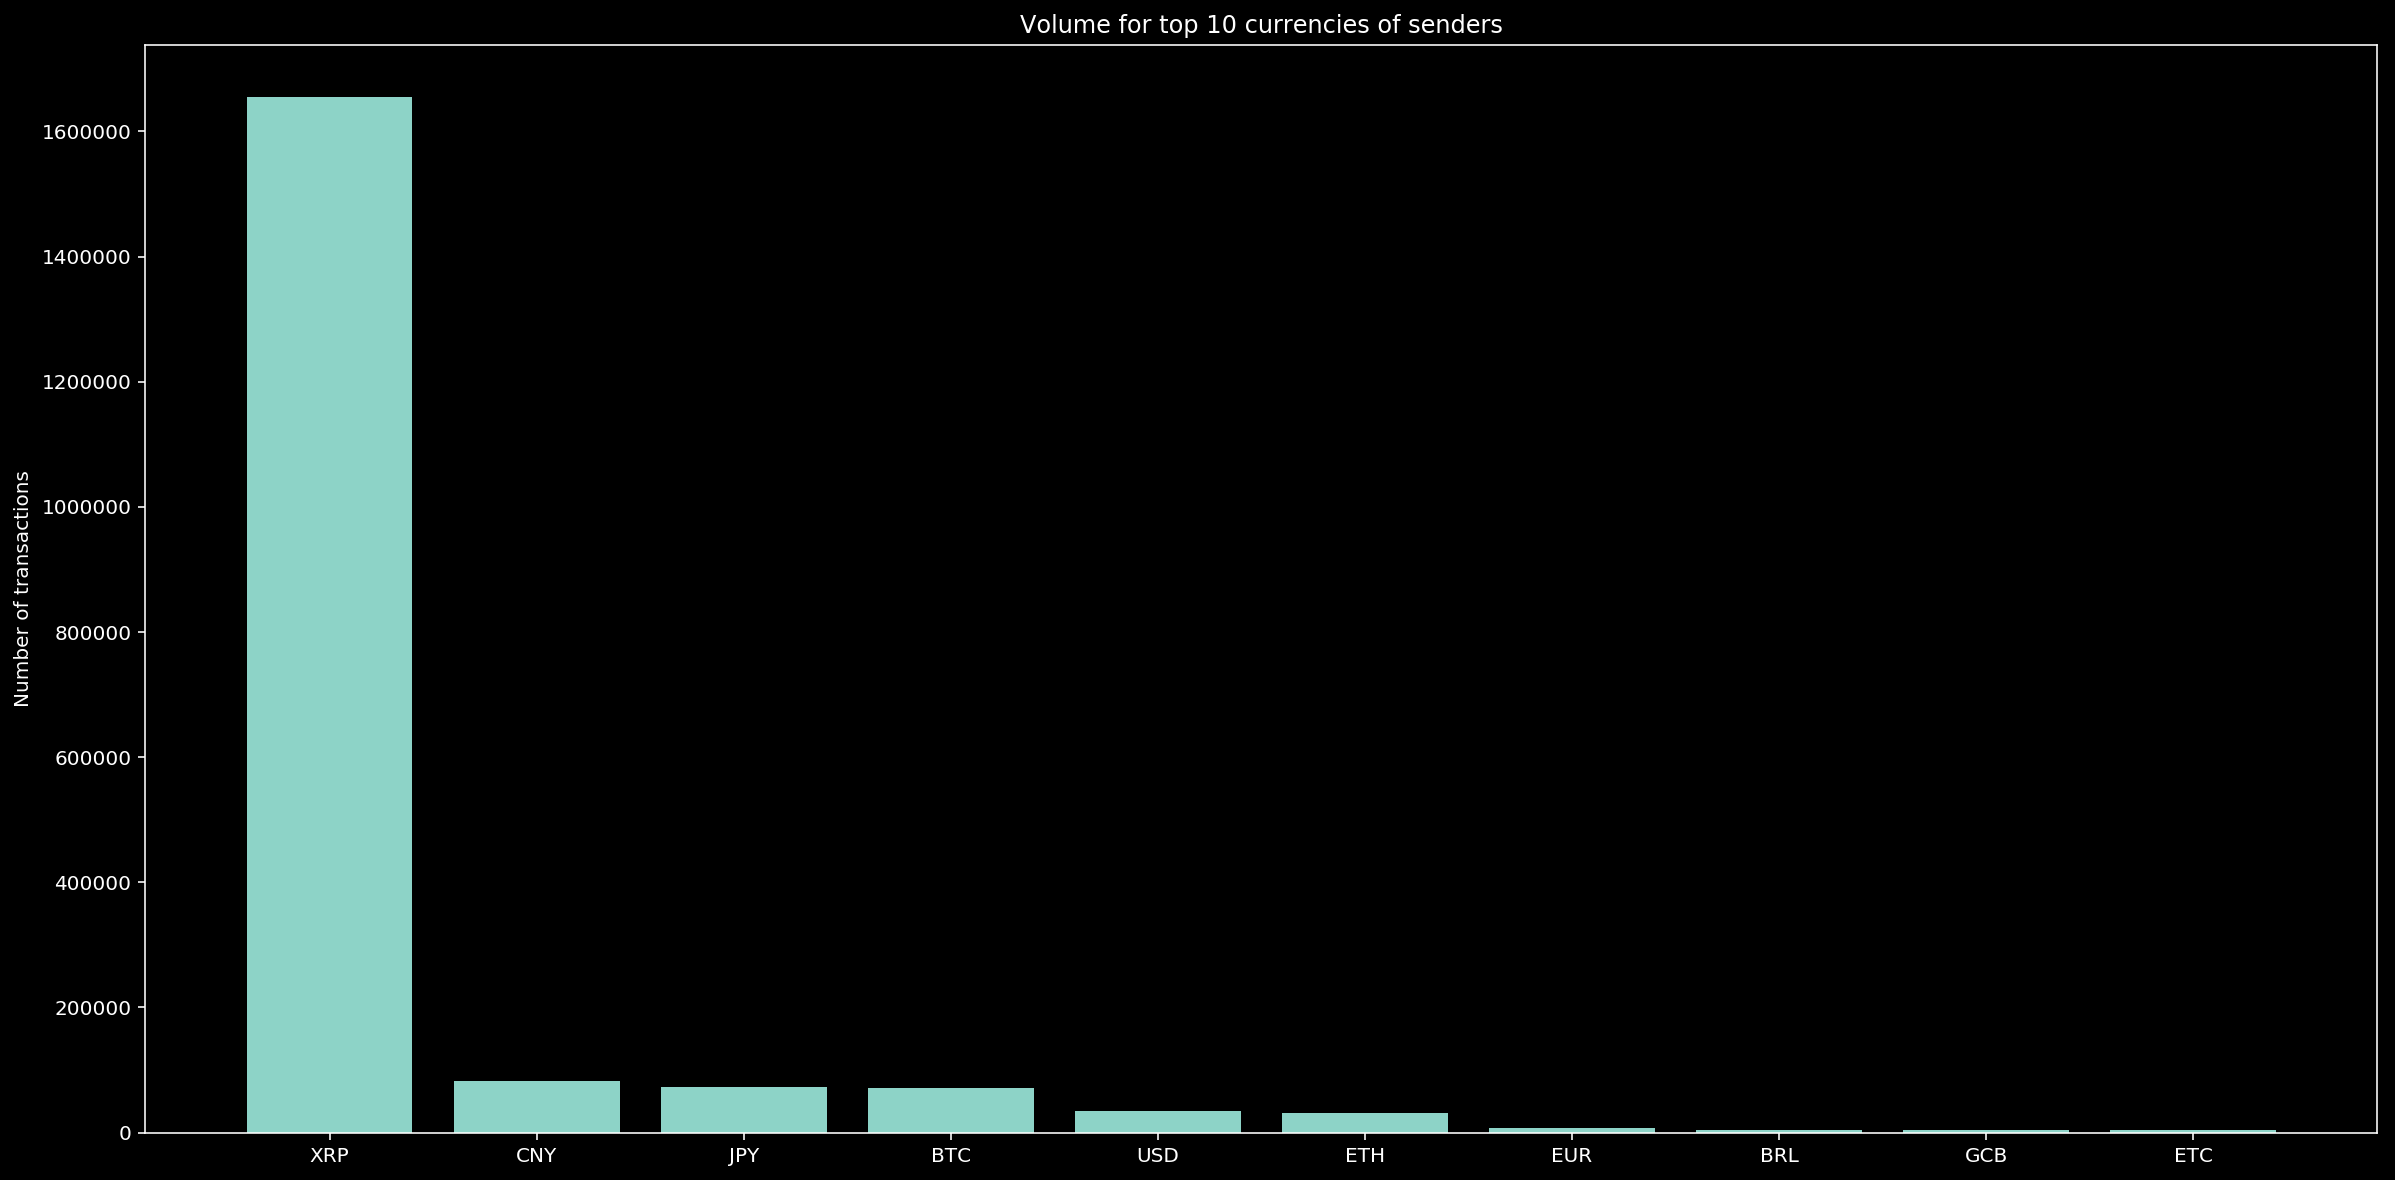

In [542]:
plot_volume(sorted_sender_currency_volume,'sender',nb_of_currencies)

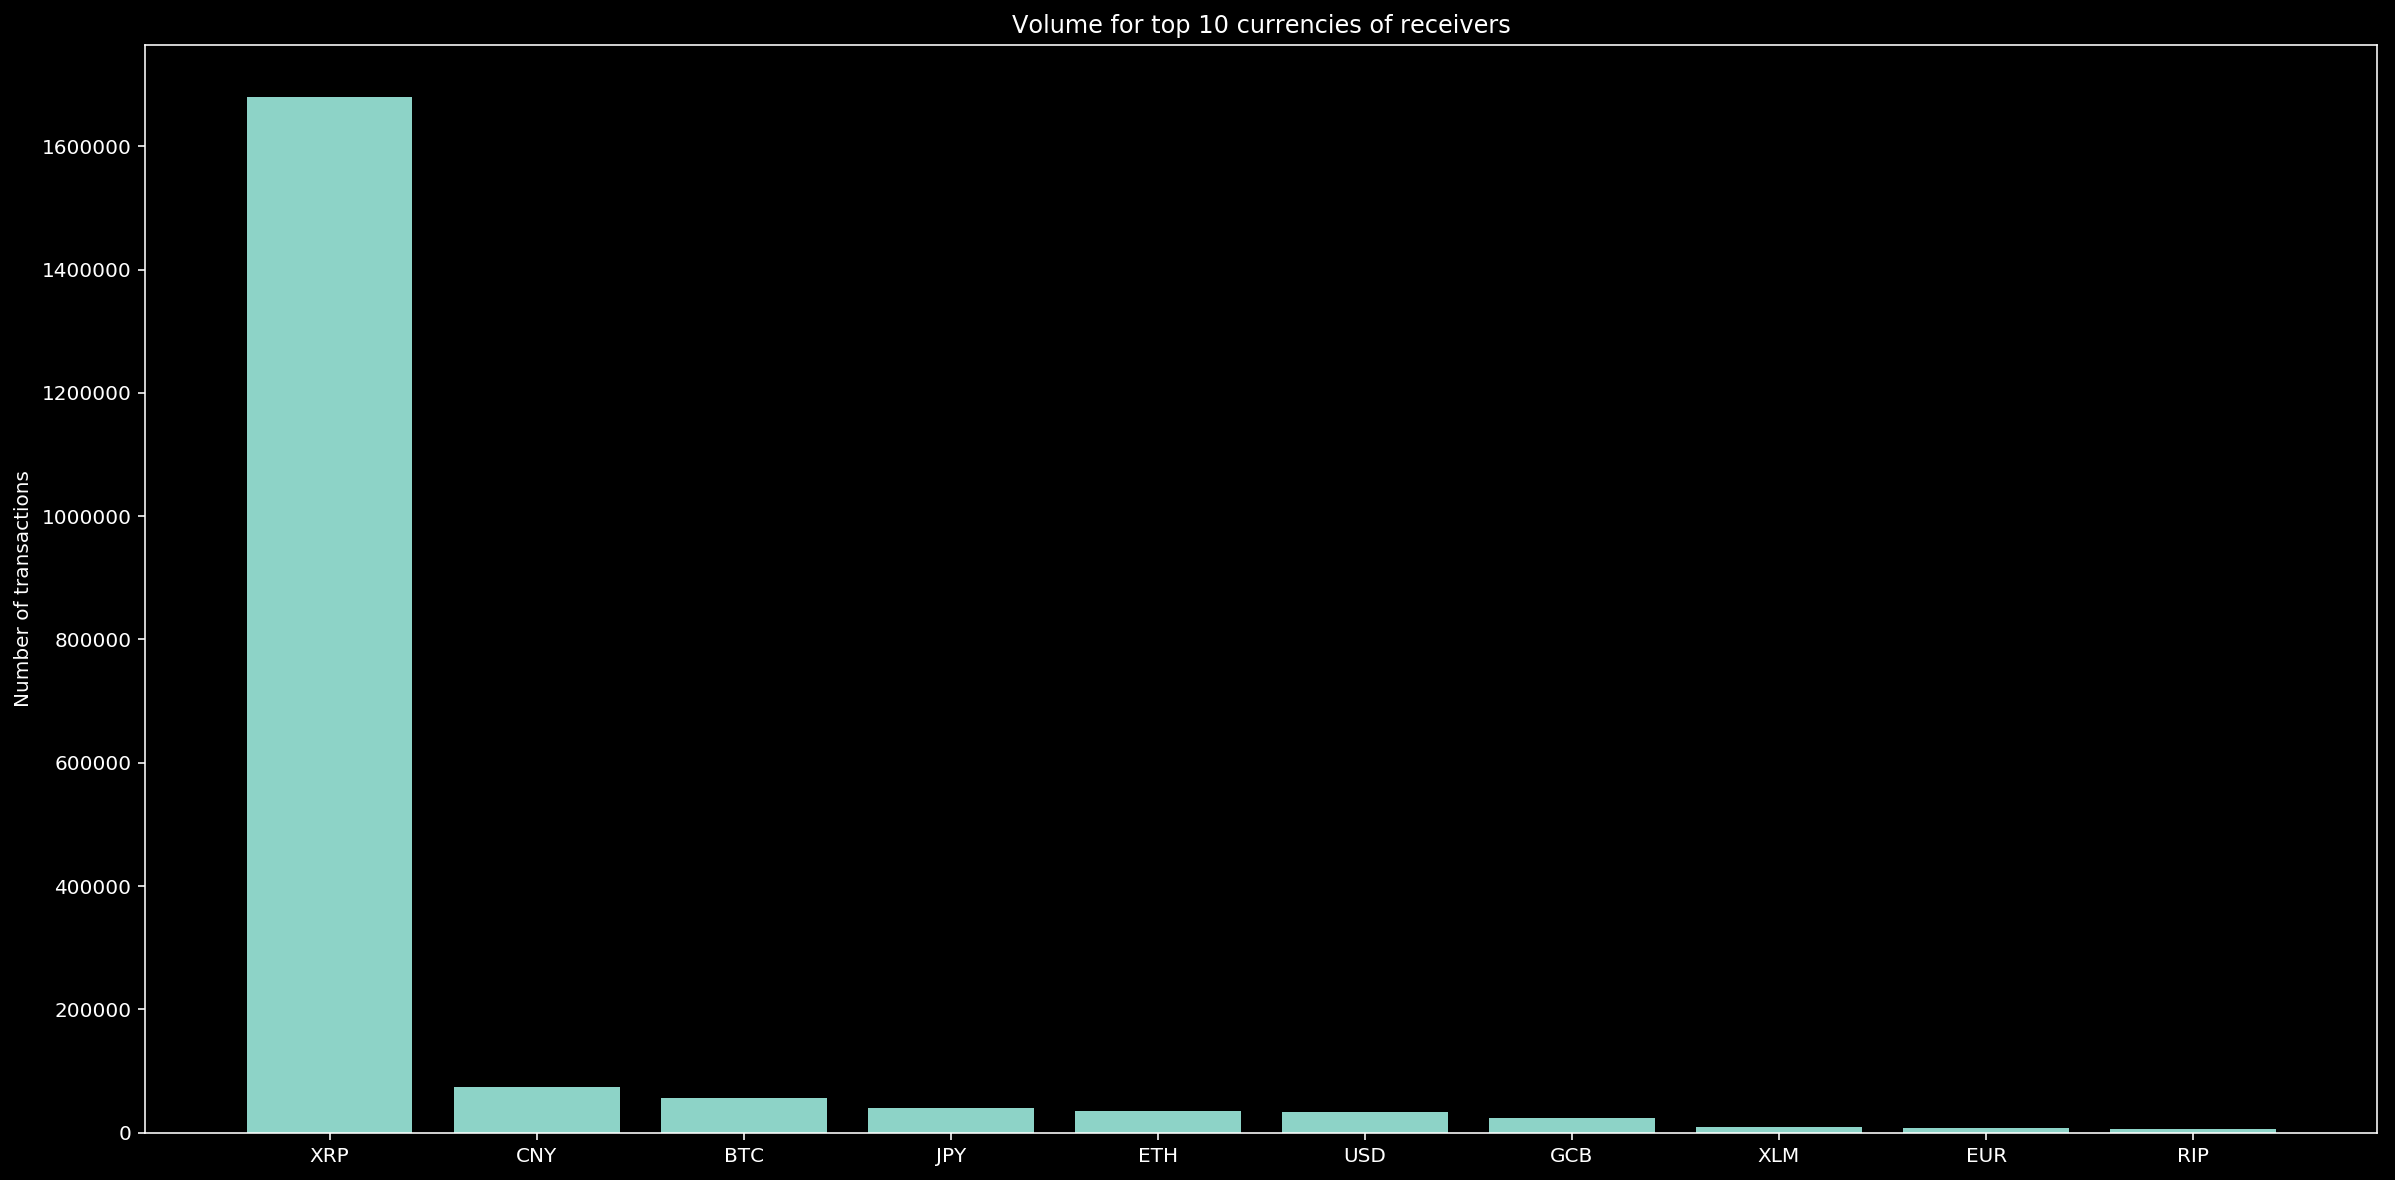

In [543]:
plot_volume(sorted_receiver_currency_volume,'receiver',10)

## 1.5 How does receiver and sender currency pairs ?

### 1.5.1 Sender side
For top used currencies in senders, what are most popular receiver currencies

In [539]:
sender_currency_to_receiver_currency = collections.defaultdict(dict) # dict {sender_curr :{receiver_curr,count}}
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        sender_curr = txn['senderCurrency']
        receiver_curr = txn['receiverCurrency']
        sender_currency_to_receiver_currency[sender_curr] = sender_currency_to_receiver_currency.get(sender_curr,{})
        sender_currency_to_receiver_currency[sender_curr][receiver_curr] = sender_currency_to_receiver_currency[sender_curr].get(receiver_curr,0) + 1 
for sender_curr, receivers_to_volume in tqdm(sender_currency_to_receiver_currency.items()):
    sender_currency_to_receiver_currency[sender_curr] = collections.OrderedDict(sorted(receivers_to_volume.items(), key=operator.itemgetter(1),reverse = True)) #order decreasing

In [546]:
nb_of_top_currencies = 10

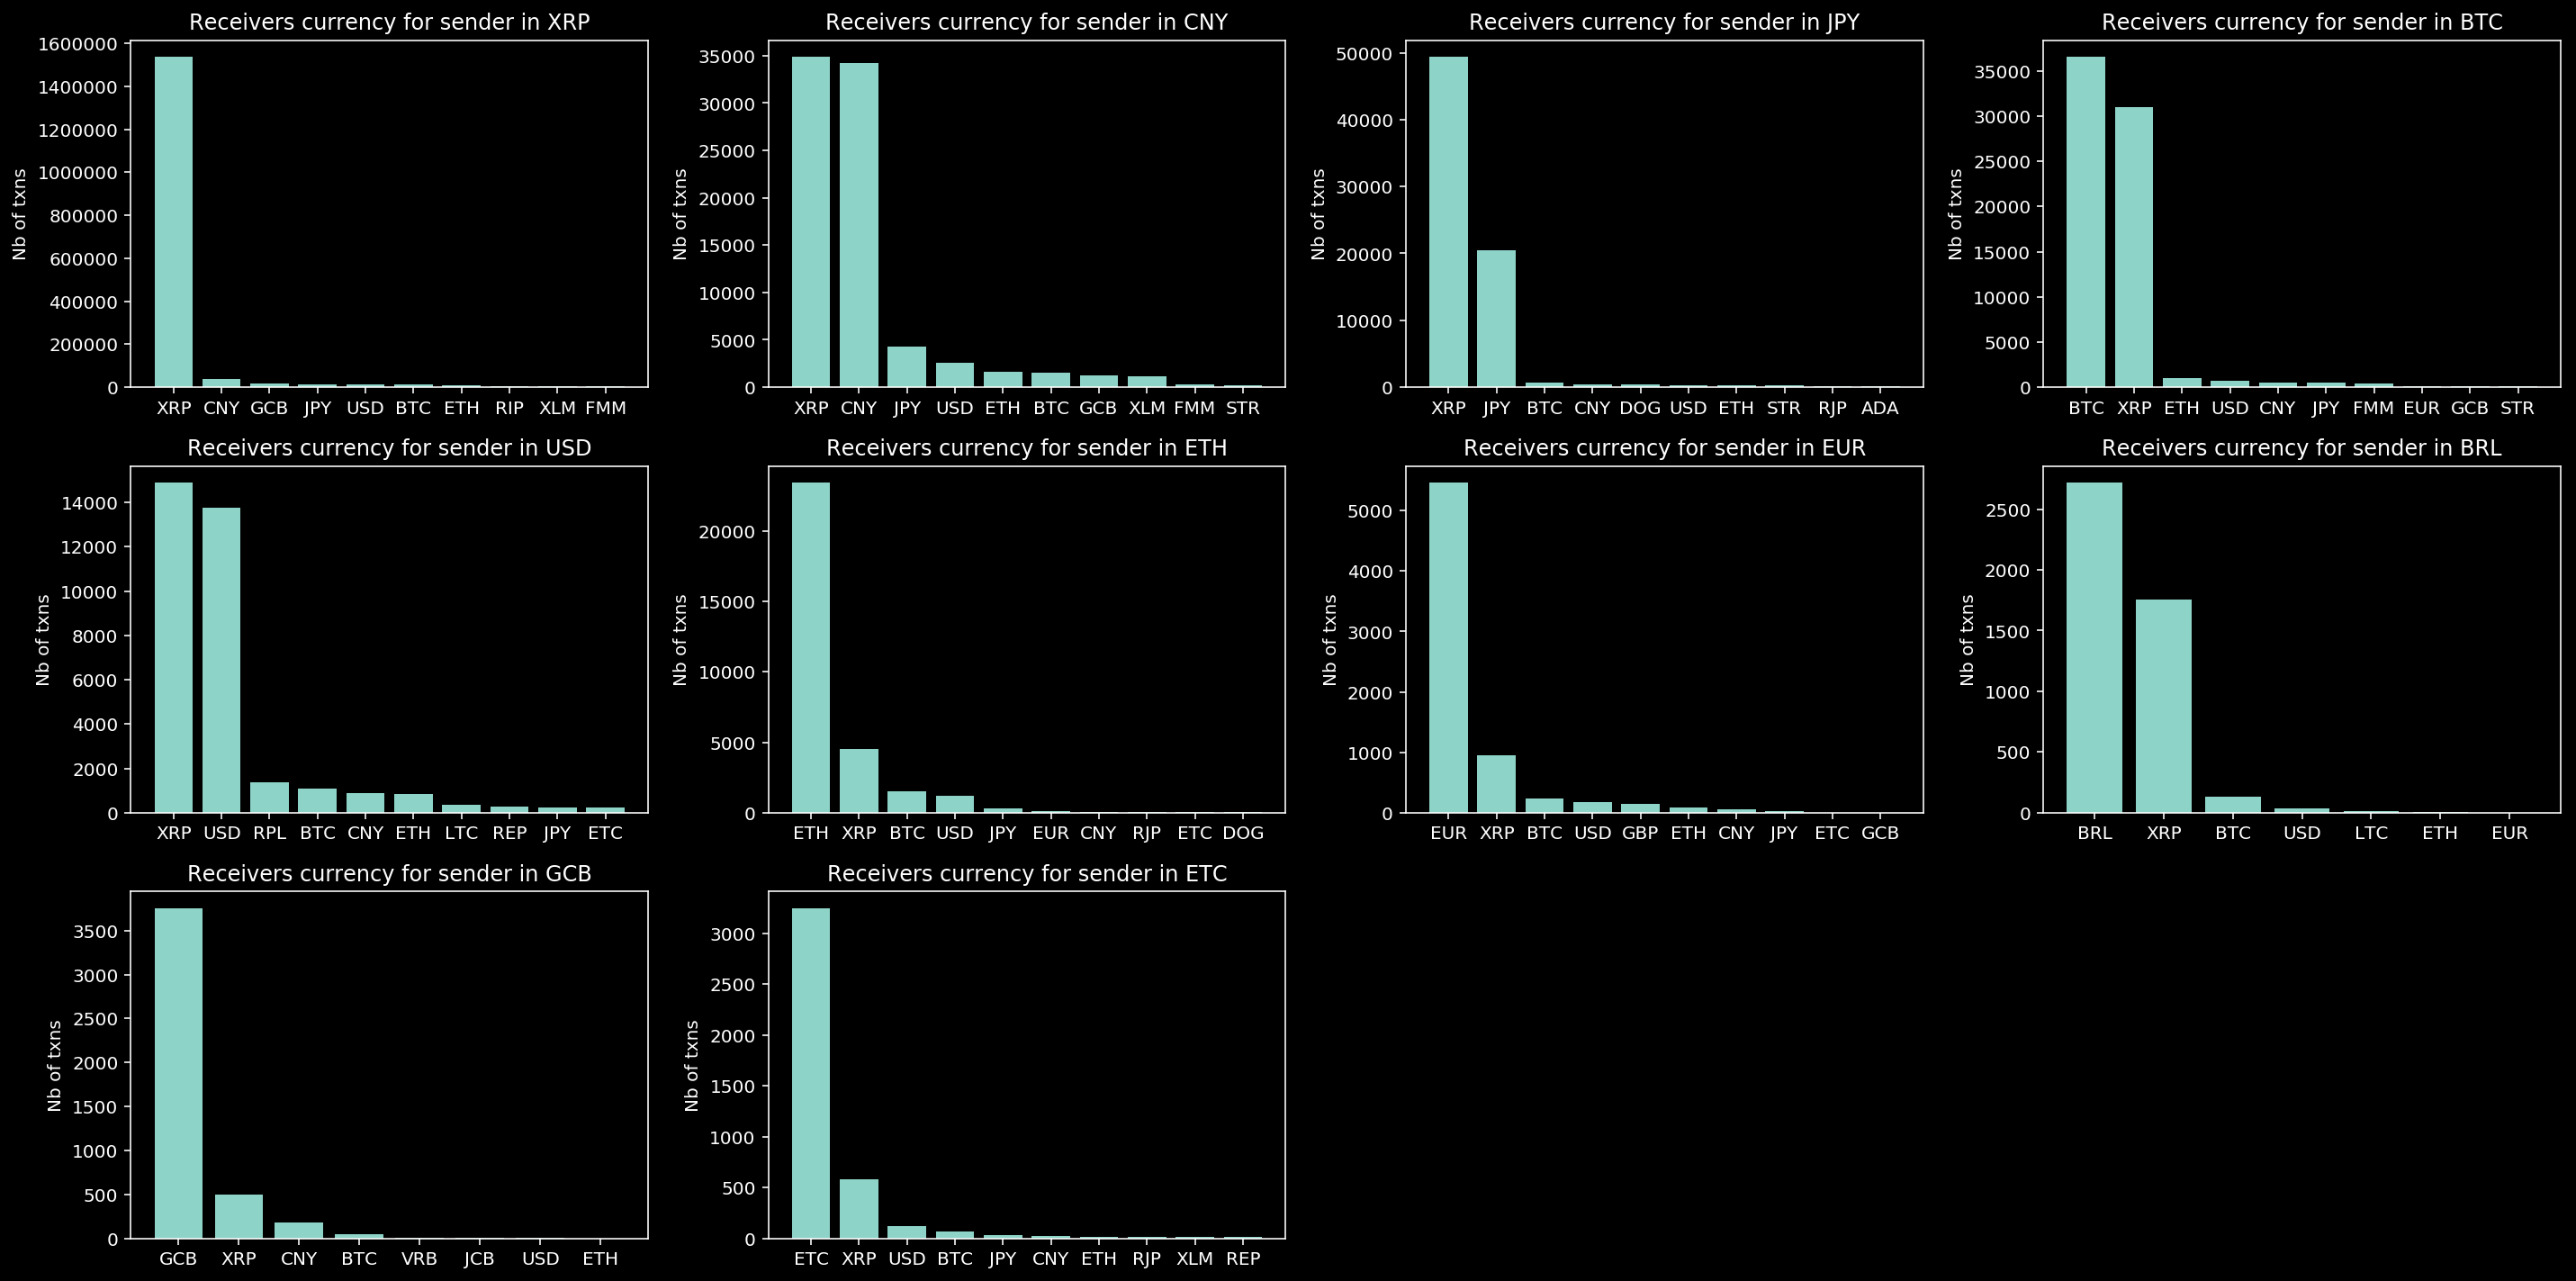

In [547]:
index = 0
for sender_currency in list(sorted_sender_currency_volume.keys())[0:nb_of_top_currencies]: #top 10 currencies of sender
    receivers_to_volume = sender_currency_to_receiver_currency[sender_currency] #get receivers_currency count (dict {currency : count})
    index+=1
    currency = list(receivers_to_volume.keys())[0:nb_of_top_currencies]
    x_pos = np.arange(len(currency))
    count = list(receivers_to_volume.values())[0:nb_of_top_currencies]
    
    plt.subplot(3,4,index)
    plt.style.use('dark_background')    

    plt.bar(x_pos, count) #bar plot
    plt.xticks(x_pos, currency)
    plt.ylabel('Nb of txns')
    plt.title('Receivers currency for sender in ' + sender_currency)
    
plt.tight_layout()
plt.show()

### 1.5.2 Receiver side
For top used currencies in receivers, what are most popular sender currencies

In [549]:
receiver_currency_to_sender_currency = collections.defaultdict(dict) # dict {receiver_curr :{sender_curr,count}}
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        sender_curr = txn['senderCurrency']
        receiver_curr = txn['receiverCurrency']
        receiver_currency_to_sender_currency[receiver_curr] = receiver_currency_to_sender_currency.get(receiver_curr,{})
        receiver_currency_to_sender_currency[receiver_curr][sender_curr] = receiver_currency_to_sender_currency[receiver_curr].get(sender_curr,0) + 1 
for receiver_curr, senders_to_volume in tqdm(receiver_currency_to_sender_currency.items()):
    receiver_currency_to_sender_currency[receiver_curr] = collections.OrderedDict(sorted(senders_to_volume.items(), key=operator.itemgetter(1),reverse = True)) #decreasing order

In [550]:
nb_of_top_currencies = 10

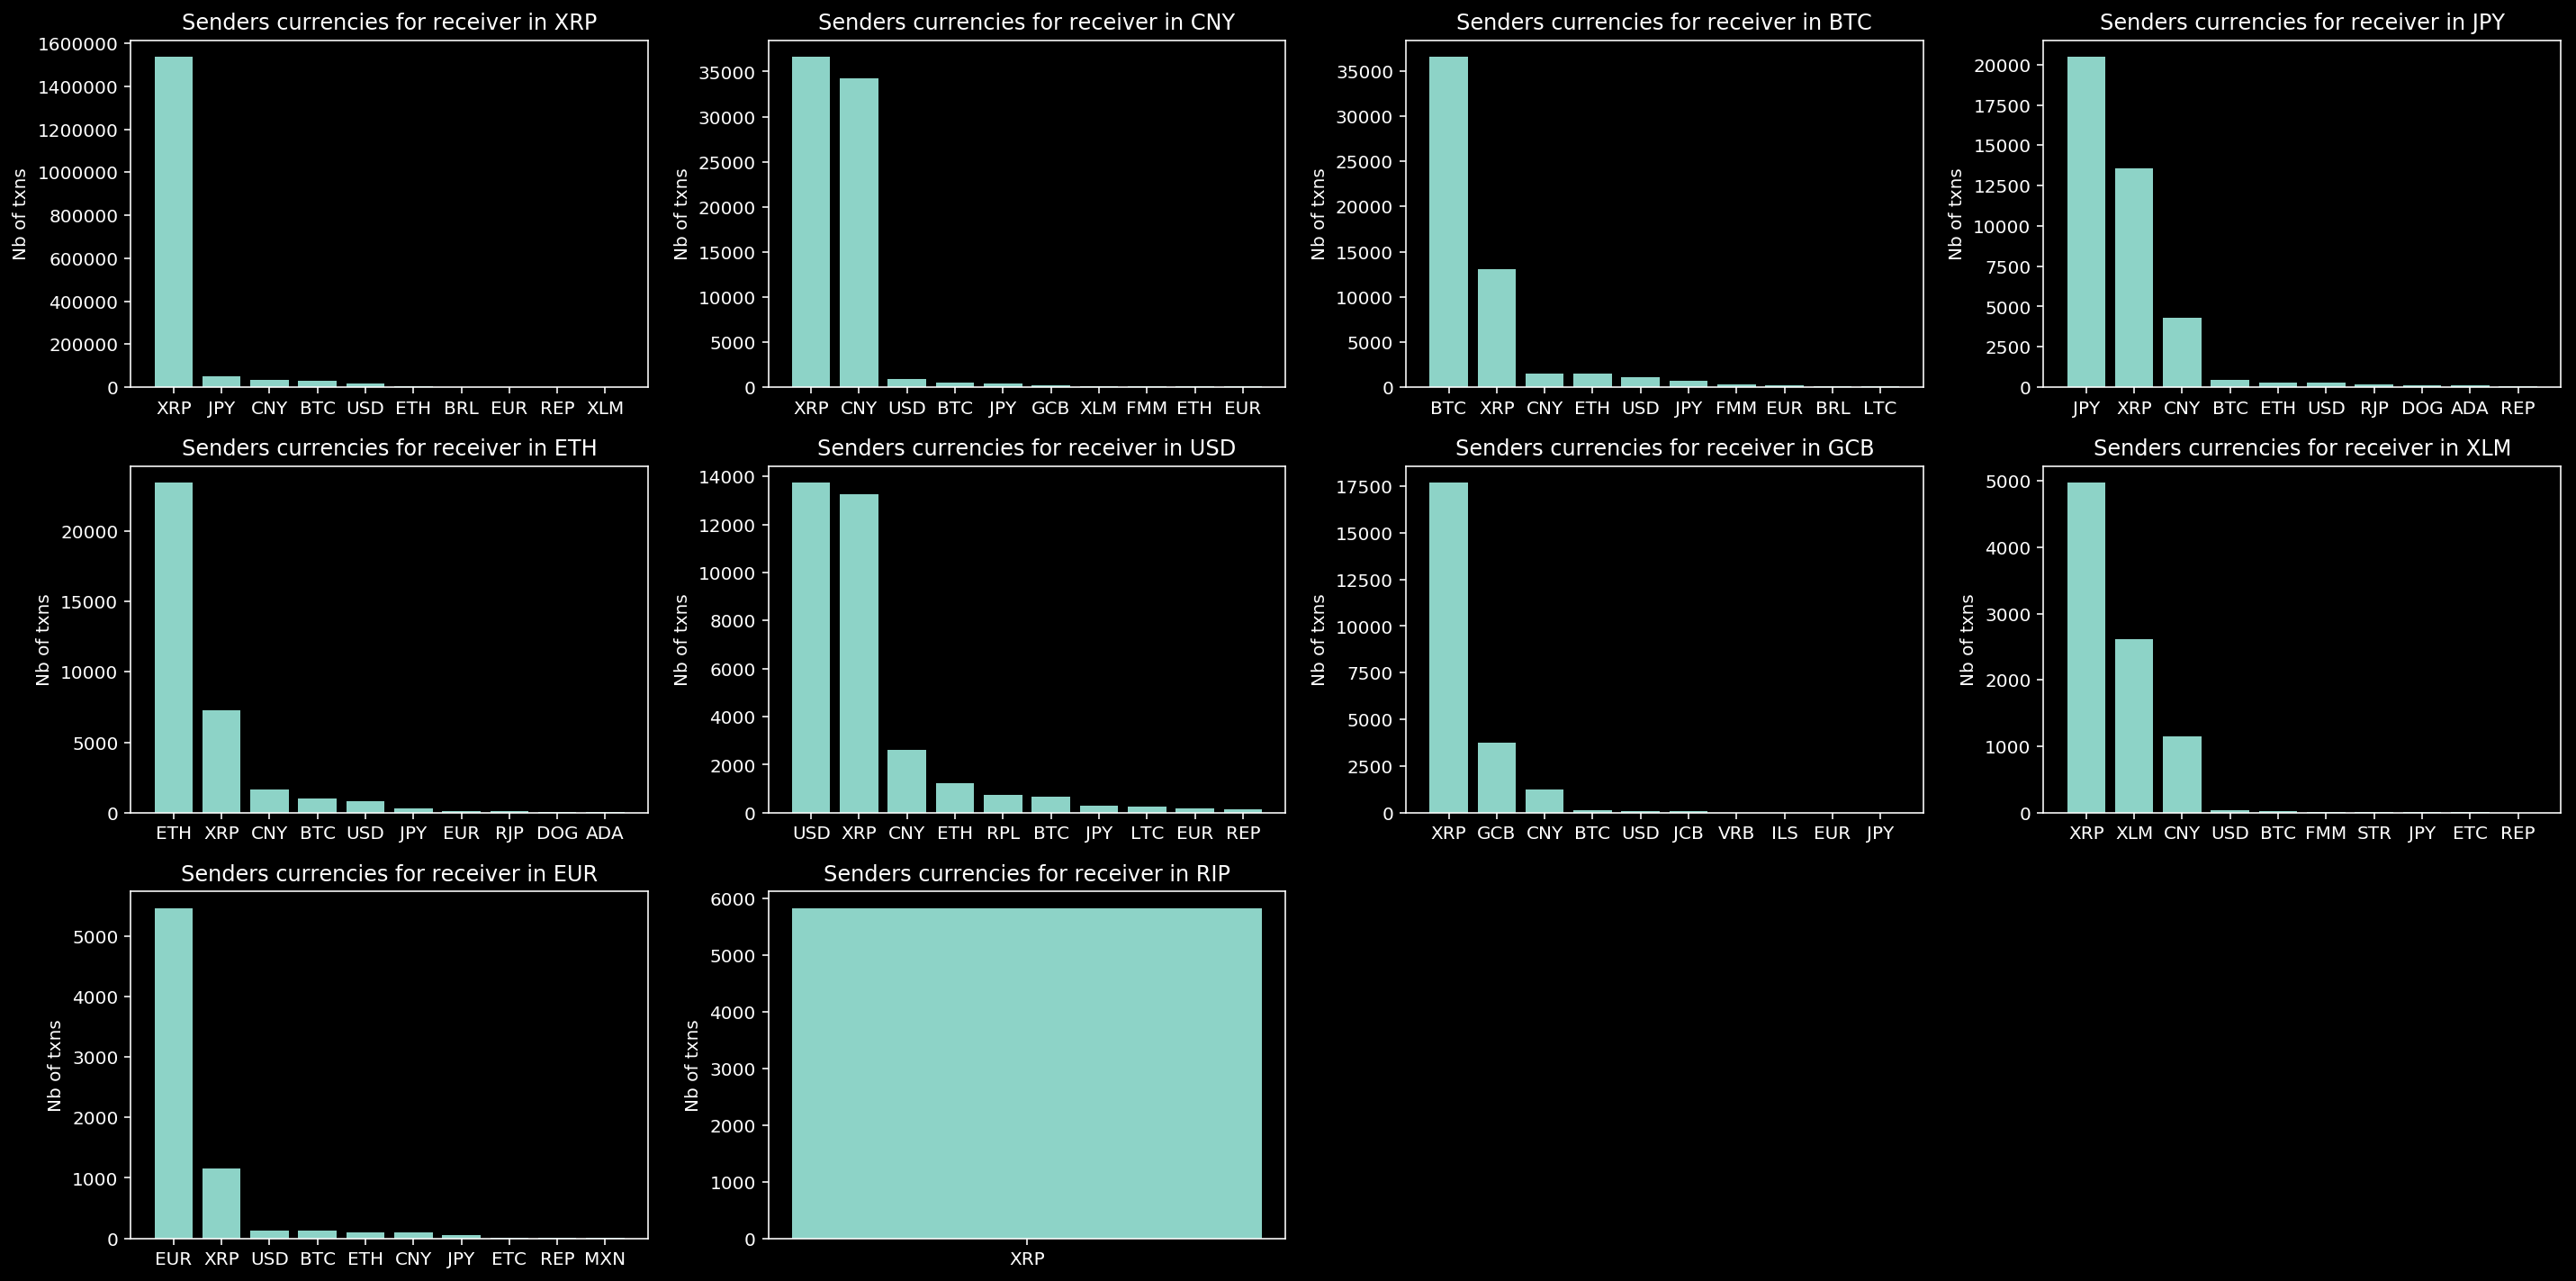

In [552]:
index = 0
for receiver_currency in list(sorted_receiver_currency_volume.keys())[0:nb_of_top_currencies]: #top 10 currencies of receiver
    senders_to_volume = receiver_currency_to_sender_currency[receiver_currency] #get senders_currency count (dict {currency : count})
    index+=1
    objects = list(senders_to_volume.keys())[0:nb_of_top_currencies]
    y_pos = np.arange(len(objects))
    performance = list(senders_to_volume.values())[0:nb_of_top_currencies]
    
    plt.subplot(3,4,index)
    plt.style.use('dark_background')    
    
    plt.bar(y_pos, performance) #bar plot
    plt.xticks(y_pos, objects)
    plt.ylabel('Nb of txns')
    plt.title('Senders currencies for receiver in '+ receiver_currency)
    
plt.tight_layout()
plt.show()

# 2. Accounts

## 2.1 Account creation (Too long using API)

In [17]:
query_params = dict(start="2012-01-01",end="2019-12-31",interval="week",family="metric",metrics="accounts_created",limit=1000)
created_accounts_per_week = api.get_stats(**query_params)

In [18]:
nb_accounts = 0
for week in tqdm(created_accounts_per_week["stats"]):
    nb_accounts += week["accounts_created"]

In [19]:
print("There are",nb_accounts,"accounts")

There are 1446292 accounts


In [ ]:
all_senders = set()
for txn in tqdm(data):
    all_senders.add(txn["sender"])

In [23]:
all_txn.update(set(df.hash.tolist()))

In [24]:
all_txn = list(all_txn_hashes)

In [28]:
nb_txn = len(all_txn)
nb_txn

27406875

Too long

In [ ]:
creation_txns = []
pbar = tqdm(total = nb_txn-1)
i=0
while(i < nb_txn):
    hsh = all_txn[i]
    transaction = api.get_transaction(hsh)
    if(list(transaction.keys()) == ['status', 'error']):
        time.sleep(int(transaction["error"].headers.get('Retry-After')) + 1)
    else:
        i+=1
        pbar.update(1)
        for affectedNode in transaction["transaction"]["meta"]["AffectedNodes"]:
            if "CreatedNode" in affectedNode.keys():
                if(affectedNode["CreatedNode"]["LedgerEntryType"] == "AccountRoot"):
                    creation_txns.append(hsh)
pbar.close()                    

In [15]:
creation_txns

['411790751304693B1ABA32443A762713CA49B67D9F995A4DA4E8FD296EDC7E40',
 '59E57301AD19F764468F3D6DA874071DDF1B40416CAD88D9F6B79673F2CAC608',
 '58A8919EBDD59FD4BEB8194D36FE09062F3247ABA2B9497DCEB56575EF3E3311',
 'EEEB8A00C0EA1687E95B94BDB39A98F827BE20EB6426CC6960DABA06CEFF1BF3',
 '40A65FEF00CB908A86D2EF2A858A7684E4BBB78739E9296E9551F68638A89E2B',
 'C112F9C5AB5FE01F7753C38EFADE2909228B27AB642DF286CA42DC6518DD2FB7',
 '2302E4FCB121561AA2DEDEE0116AD451A982993A0DB6731FDD1DA78B511DDB51',
 'EC283B2A36D56685539F1DA284EE1E9125580299968B0C7FFD73E6FCBD16F7EF',
 'E1373B461997CFFE390FC45B3F75BA99C6966A37098638A6278F9EE5EEFB3891',
 '4AA7EFDABA33F1552FF4C536EAE65CBA605D7FA61CE765F9D9E79C8444FAF3B3',
 'FABD792DB5B44B70087FE5D1DA2E6D82B802F847871BD3D73F0AA43B6B0BB9BF',
 '08D4A53414F1B6629BCFB60498D1982DC027CE5267B47411B01DD7ADC77ECA17',
 '9819BF1E715263A59D781C1BCB5FB6036917955394017E3C97BE19336B8F753E',
 'E6D2C569927E0F5853FA138BF760B9F43A46B0F6ABB44B9684C40380DF67ADFD',
 'DF14E2B855218E0181AAB1E949F8C913

## 2.2 How many times account make transactions

We want to know it senders appears several times in transactions

In [32]:
all_senders = df.sender.tolist() #all_senders is a list (with duplicates)

In [33]:
for txn in tqdm(data):
    all_senders.append(txn["sender"])

In [34]:
nb_txn_by_sender = Counter(all_senders).most_common() #count nb of occurences of each sender and sort them reverse

In [35]:
set_senders = set(all_senders) #senders with no duplicates

In [37]:
senders_with_at_least_2_txn = [ sender for sender, occurence in tqdm(list(nb_txn_by_sender)) if occurence > 1 ]

In [38]:
print("There are", len(senders_with_at_least_2_txn)/len(set_senders)*100, "% of senders than appears at least two times")

There are 59.685003878942325 % of senders than appears at least two times


# 3. Trust lines

## 3.0 Getting trust lines

In [10]:
all_wallets = set(df.sender.tolist())|set(df.sender.tolist())

In [11]:
for txn in tqdm(data):
    all_wallets.add(txn["sender"])
    all_wallets.add(txn["receiver"])

In [13]:
all_wallets = list(all_wallets)

Next cell is very long

In [14]:
def get_lines(id):
    answer = rpc.account_lines(all_wallets[id])
    if(answer["status"] == 'success'):
        return answer
    else:
        print("error")
        return

In [15]:
def get_lines_range(id_range, store=None):
    """process a number of ids, storing the results in a dict"""
    if store is None:
        store = []
    for id in tqdm(id_range):
        store.append(get_lines(id))
    return store

In [16]:
from threading import Thread

def threaded_process(nthreads, id_range):
    """process the id range in a specified number of threads"""
    store = []
    threads = []
    # create the threads
    for i in range(nthreads):
        ids = id_range[i::nthreads]
        t = Thread(target=get_lines_range, args=(ids,store))
        threads.append(t)

    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return store

In [ ]:
lines = threaded_process(4, range(len(all_wallets)))

In [18]:
while None in lines:
    lines.remove(None)

In [19]:
with open('lines.pckl', 'wb') as f:
    pickle.dump(lines, f)

## 3.1 Trust lines with gateways

First we get the informations about the gateways with the ripple data API:

In [268]:
gateways = api.get_all_gateways()
#online_gateways = ['SnapSwap','Gatehub Fifth','Bitstamp','Payroutes','WisePass','The Rock Trading','RippleChina','DotPayco','Coinex','Ripple Fox','Lake BTC','Bitso','GBI','Gatehub','EXRP','BPG']

In [ ]:
gateways_address = set() #all gateway addresses
address_to_gateway = {}
#online_gateways_address = set()
for k,vs in tqdm(gateways.items()):
    for v in vs:
        gateways_address.add(v["account"])
        address_to_gateway[v['account']] = v['name']
        #if v['name'] in online_gateways:
            #online_gateways_address.add(v["account"])

We want :
* know what are the most popular wallet in trust lines
* Map wallet to countries given their trust lines currency 

In [23]:
ctr_lines_with_gateways = 0 #counter for the number of trust lines with gateways
ctr_lines = 0 #counter for the number of trust lines
account_to_currency = collections.defaultdict(list) #dict from account to countries (based on currency of its trust lines)
wallet_count_in_trust_lines = {} #count in how many trust lines a wallet appear
for info in tqdm(lines): 
    for line in info["lines"]:
        ctr_lines += 1
        wallet_count_in_trust_lines[line["account"]] = wallet_count_in_trust_lines.get(line["account"], 0) + 1
        if line["account"] in gateways_address:
            ctr_lines_with_gateways += 1
            
            #try to convert trust line currency into country, could fail if currency is not fiat (ex : BTC)
            try: 
                currency = ccy.currency(line["currency"]).code
                if(currency not in account_to_currency[info["account"]]):
                    account_to_currency[info["account"]].append(currency)
            except:
                continue

Now that we have collected the data we wanted, let's analyse it :
 * 3.1.1 What percentage of trust lines are with gateways
 * 3.1.2 Most Common wallets in trust lines 
 * 3.1.3 Over the accounts with trust lines, how many have one with a gateway
 * 3.1.4 Over all accounts, how many have a trust line with a gateway
 * 3.1.5 Currency of trust lines with gateways

### 3.1.1 What percentage of trust lines are with gateways

In [24]:
print("There are", ctr_lines_with_gateways/ctr_lines*100,"% of thurst lines that are with gateways")

There are 69.24400759363412 % of thurst lines that are with gateways


### 3.1.2 Most Common wallets in trust lines 

In [25]:
wallet_occurences = [(k,v) for k,v in list(wallet_count_in_trust_lines.items())] # convert dict to list of pairs

In [26]:
wallet_occurences.sort(reverse = True,key=lambda wallet_occurences: wallet_occurences[1]) # sort by decressing occurence

In [27]:
gateway_occurences = [(k,v) for k,v in wallet_occurences if k in gateways_address]  # get occurences in trust lines for gateways

In [28]:
gateway_top = [i for i,j in zip(wallet_occurences,gateway_occurences) if i == j] # get first matching elements in occurence of wallets and gateways

In [29]:
print("The",len(gateway_top),"most common wallet in trust lines are gateways")

The 7 most common wallet in trust lines are gateways


### 3.1.3 Over the accounts with trust lines, how many have one with a gateway

In [30]:
nb_account_with_turst_lines = len([x for x in lines if len(x["lines"]) >= 1]) #nb of accounts with at least one trust line

In [32]:
nb_account_with_trust_lines_with_gateways =len(account_to_currency.keys()) #nb of accounts with trust line with gateways

In [33]:
print("Over the accounts that have a trust line",nb_account_with_trust_lines_with_gateways/nb_account_with_turst_lines* 100,"% of them have one with a gateway.")

Over the accounts that have a trust line 69.59407239337753 % of them have one with a gateway.


### 3.1.4 Over all accounts, how many have a trust line with a gateway

In [34]:
print("Over all accounts",nb_account_with_trust_lines_with_gateways/len(lines)*100,"% of them have a trust line with a gateway.")

Over all accounts 30.165252427154627 % of them have a trust line with a gateway.


### 3.1.5 Currency of trust lines with gateways

In [36]:
count_len = {}
for country_list in tqdm(account_to_currency.values()):
    # how many wallets are associated with "n" countries
    count_len[len(country_list)] = count_len.get(len(country_list),0) + 1 
for k,v in count_len.items():
    #percentage of total number of wallets that has trust lines with gateways
    count_len[k] = v/nb_account_with_trust_lines_with_gateways*100 

In [37]:
print("Over the wallets that have trust lines with gateways",count_len[1],"% of them have trust lines with gateways in just 1 currency")
print("And",count_len[2],"% of them have trust lines with gateways in 2 currencies")

Over the wallets that have trust lines with gateways 75.94343467275246 % of them have trust lines with gateways in just 1 currency
And 19.944575760045645 % of them have trust lines with gateways in 2 currencies


### 3.1.6 Volume of transaction via trust line for wallets with trust lines in 1 or 2 currencies

In [38]:
account_to_volume = collections.defaultdict(dict)
for txn in tqdm(data):
    if(txn['success'] == 'tesSUCCESS'):
        account = txn['sender']
        if account in account_to_currency.keys():
            currency_list = account_to_currency[account]
            if len(currency_list) < 3:
                if 'senderCurrency' in txn.keys():
                    sender_currency = txn['senderCurrency']
                    if sender_currency in currency_list:
                        account_to_volume[account] = account_to_volume.get(account,{})
                        account_to_volume[account][sender_currency] = account_to_volume[account].get(sender_currency,0) + 1
                    else:
                        account_to_volume[account] = account_to_volume.get(account,{})
                        account_to_volume[account]['others'] = account_to_volume[account].get('others',0) + 1
                else:     
                    account_to_volume[account] = account_to_volume.get(account,{})
                    account_to_volume[account]['others'] = account_to_volume[account].get('others',0) + 1

In [39]:
for account, volume_list in tqdm(account_to_volume.items()):
    for currency, volume in volume_list.items():
        sum_volume = sum(volume_list.values())
        account_to_volume[account][currency] = account_to_volume[account][currency]/sum_volume*100

In [40]:
for k,v in list(account_to_volume.items())[0:5]:
    print(k,v)

rB9bef3eimfL8pUvVmY1xeEbFDGx1K4XQZ {'others': 100.0}
rDLCE1RxnEB2HH62B6TaP4oBuA8H3zBeVm {'others': 99.87113402061856, 'USD': 0.9913638918697941}
r9jqtmmTdiShiKxy7beoyJZPD9MYACkJpk {'CNY': 98.65591397849462, 'USD': 4.823651452282158}
r4f6dHWbSxWRdyBVSPaqKhJWnksfCe6doq {'others': 100.0}
r9qRTJ33PF5YgRAEiVgr62z8JhuNunGkVg {'others': 100.0}


In [41]:
never_currency_of_trust_line = 0
for volume in tqdm(account_to_volume.values()):
    if(volume == {'others': 100.0}):
        never_currency_of_trust_line+= 1

In [42]:
print('We have',never_currency_of_trust_line/len(account_to_volume)*100,'% of wallets that have trust line that never use the currencies of their trust lines')

We have 69.06093078635399 % of wallets that have trust line that never use the currencies of their trust lines


## 3.2 How Wallet use their trust lines

In [43]:
wallet_to_gateway_trust_lines = collections.defaultdict(list)
for account_line in tqdm(lines):
    for line in account_line['lines']:
        if line['account'] in gateways_address:
            wallet = account_line['account']
            wallet_to_gateway_trust_lines[wallet].append((line['account'],line['currency']))

### 3.2.1 Senders

We want to see if transactions goes mainly through trust lines with gateways

In [294]:
usage_of_trust_lines = collections.defaultdict(dict)

# For a given currency transactions checks 
# if the senders uses one of its trust lines with gateways for this currency in the transaction
#     increment the counter for the this line
# else
#     if the sender uses a trust line that is not with a gateways OR makes a direct transaction in this currency
#         increment the counter for 'others'

def get_result(txn):
    account = txn['sender']
    if(account in wallet_to_gateway_trust_lines.keys()):
        trust_lines = wallet_to_gateway_trust_lines[account]
        #go first through the gateways 
        for trust_line in trust_lines:  
            trust_line_account = trust_line[0]
            trust_line_gateway = address_to_gateway[trust_line_account]
            trust_line_currency = trust_line[1]
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line[0] == link['node2'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line[0] == link['node1'] and trust_line_currency == link['currency'])):
                        usage_of_trust_lines[trust_line_currency] = usage_of_trust_lines.get(trust_line_currency,{})
                        usage_of_trust_lines[trust_line_currency][trust_line_gateway] = usage_of_trust_lines[trust_line_currency].get(trust_line_gateway,0) + 1
                        return
                            
        #if transaction does not go through a gateway look if it uses a other path             
        for trust_line in trust_lines:  
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line_currency == link['currency'])):
                        usage_of_trust_lines[trust_line_currency] = usage_of_trust_lines.get(trust_line_currency,{})
                        usage_of_trust_lines[trust_line_currency]['other'] =  usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                        return
                            
            #or if it's direct                  
            elif 'senderCurrency' in txn.keys():
                if txn['senderCurrency'] == trust_line_currency:
                    usage_of_trust_lines[trust_line_currency] = usage_of_trust_lines.get(trust_line_currency,{})
                    usage_of_trust_lines[trust_line_currency]['other'] = usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                    return
                        
#go through all transactions
for txn in tqdm(data):
    if(txn['success'] == 'tesSUCCESS'):
        get_result(txn)
        
for currency, gateway_to_volume in tqdm(usage_of_trust_lines.items()):
    usage_of_trust_lines[currency] = collections.OrderedDict(sorted(gateway_to_volume.items(),key=operator.itemgetter(1),reverse = True))

In [296]:
nb_of_top_currencies = 10

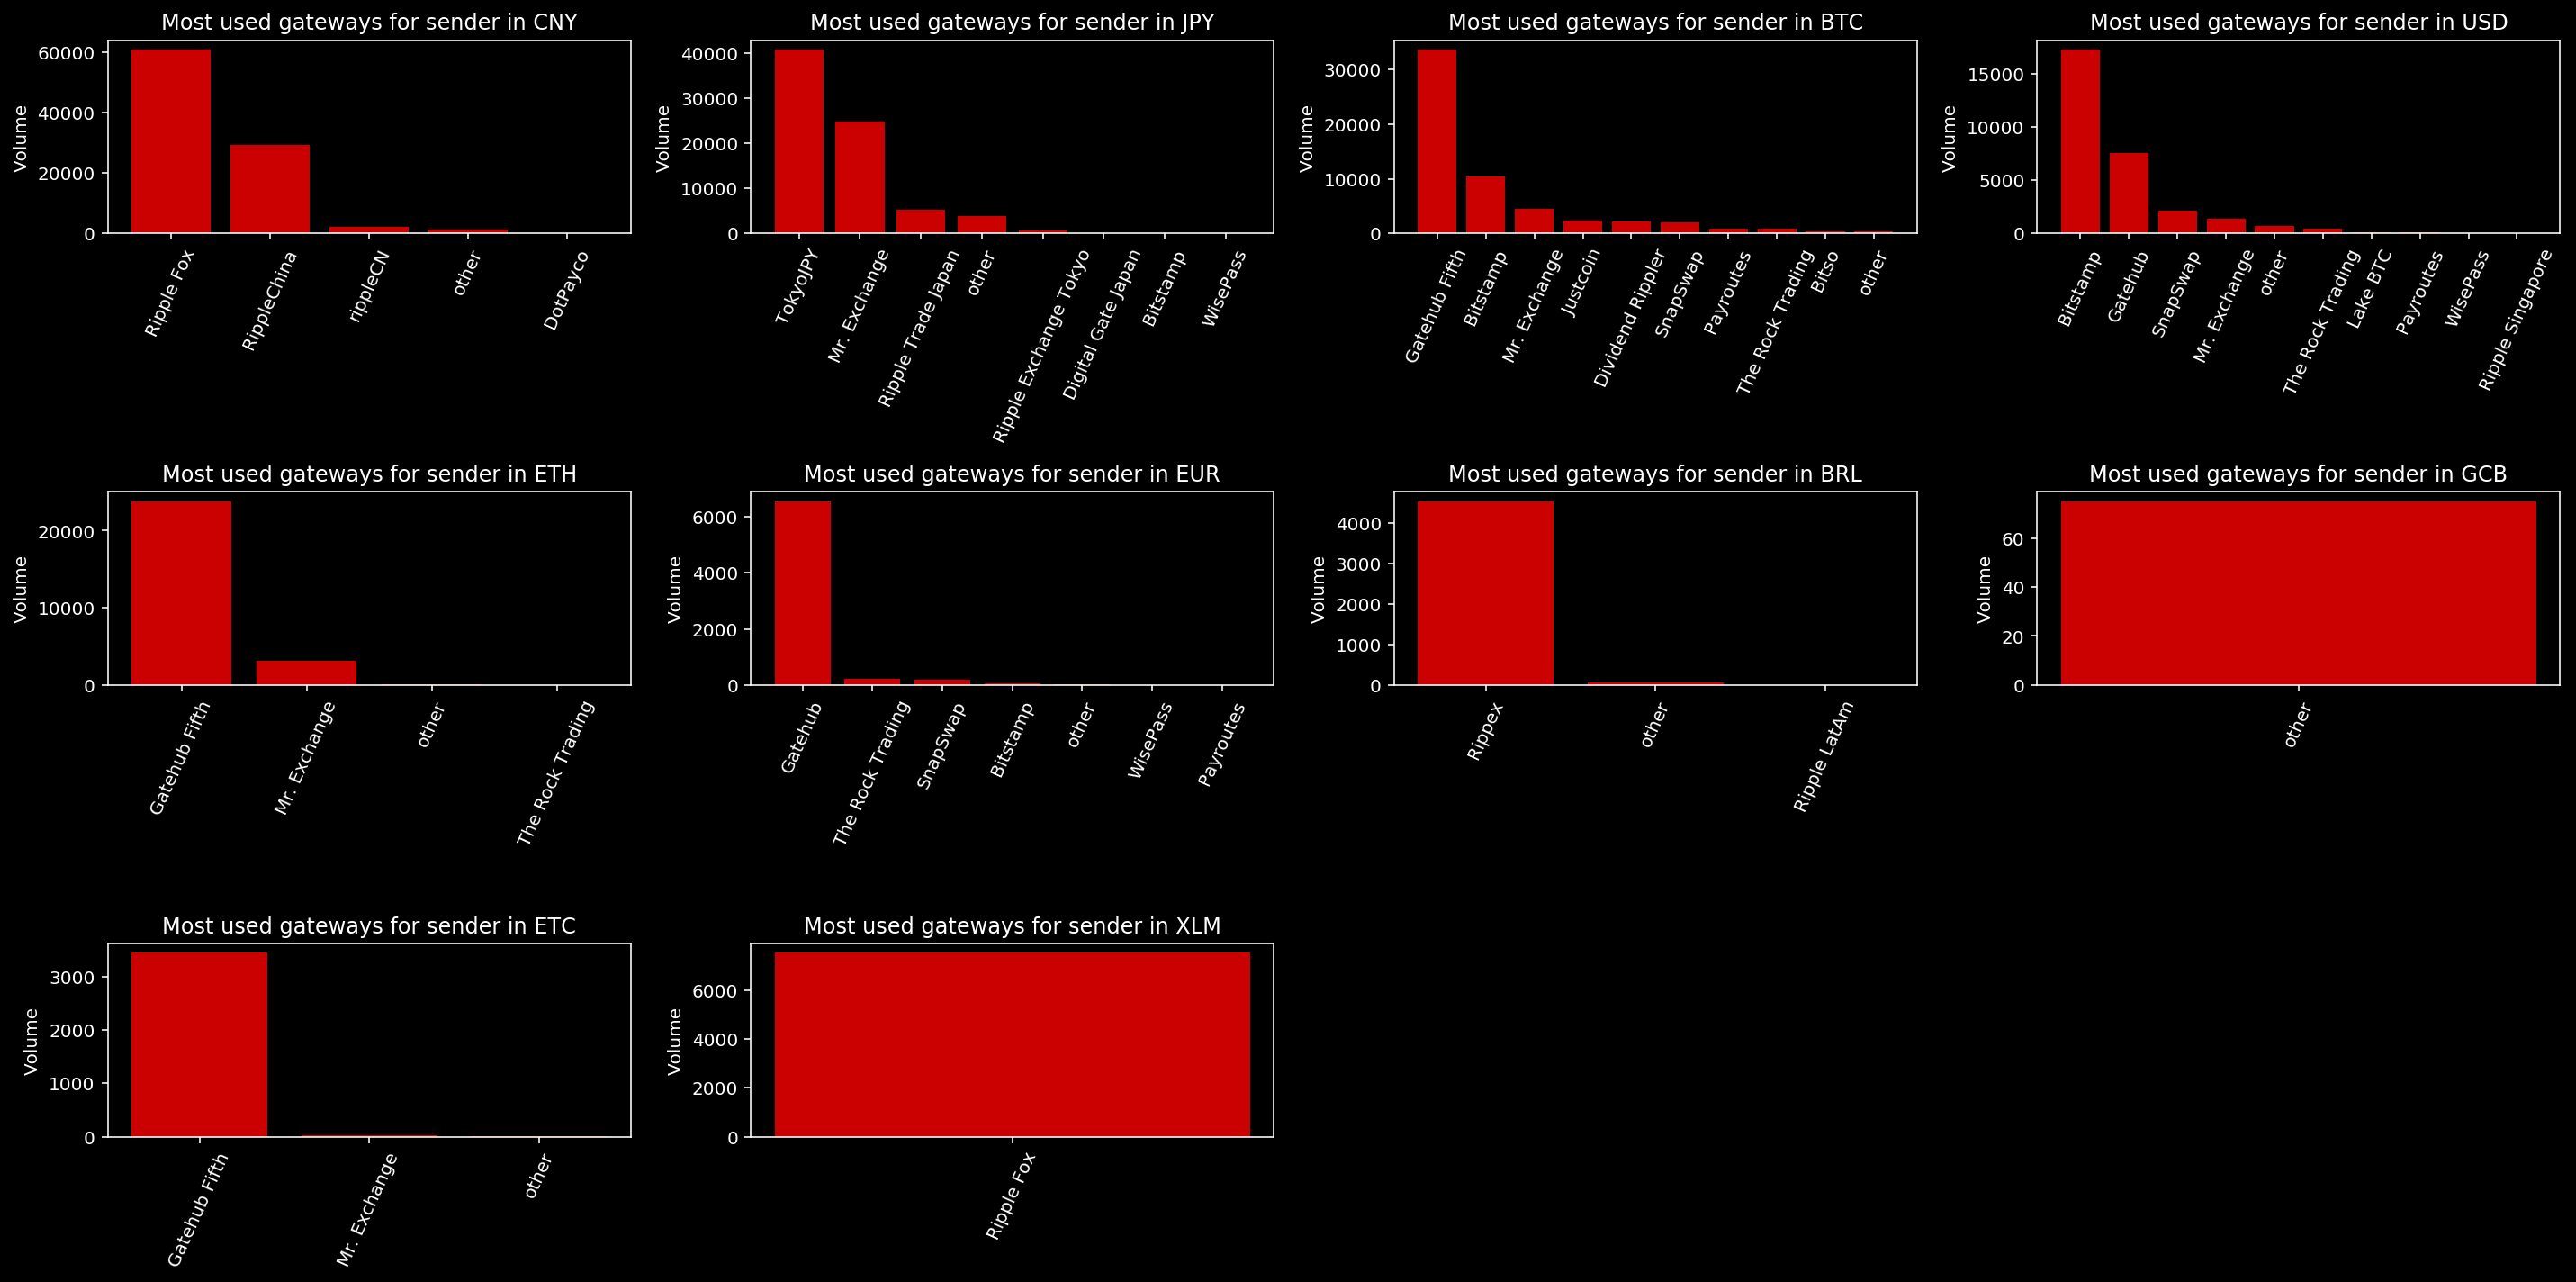

In [340]:
index = 0
for sender_currency in list(sorted_sender_currency_volume.keys()): #top 10 currencies of sender
    if (sender_currency in usage_of_trust_lines.keys()) and (index < nb_of_top_currencies):
        trust_line_usage = usage_of_trust_lines[sender_currency] #get senders_currency count (dict {currency : count})
        index+=1
        objects = list(trust_line_usage.keys())[0:nb_of_top_currencies]
        y_pos = np.arange(len(objects))
        performance = list(trust_line_usage.values())[0:nb_of_top_currencies]
    
        plt.subplot(3,4,index)
        plt.style.use('dark_background')    
    
        plt.bar(y_pos, performance) #bar plot
        plt.xticks(y_pos, objects,rotation = 65.5)
        plt.ylabel('Nb of transactions')
        plt.title('Most used gateways for sender in ' + sender_currency)
    
plt.tight_layout()
plt.show()

Now count how many txn goes through gateways and how many does not.

In [307]:
count_through_gateways = 0
count_others = 0
for account, currencies in tqdm(usage_of_trust_lines.items()):
    for gateway,count in currencies.items():
        if gateway == 'other':
            count_others += value
        else:
            count_through_gateways += value

In [308]:
print("For wallets that have trust line with gateways in a given currency, there are in average", count_through_gateways/(count_through_gateways+count_others)*100,'% of payments in that currency made by this wallet via these trust lines with gateways') 

For wallets that have trust line with gateways in a given currency, there are in average 85.34482758620689 % of payments in that currency made by this wallet via these trust lines with gateways


### 3.2.2 Receivers

In [314]:
receiver_usage_of_trust_lines = collections.defaultdict(dict)

# For a given currency transactions checks 
# if the senders uses one of its trust lines with gateways for this currency in the transaction
#     increment the counter for the this line
# else
#     if the sender uses a trust line that is not with a gateways OR makes a direct transaction in this currency
#         increment the counter for 'others'

def get_result(txn):
    account = txn['receiver']
    if(account in wallet_to_gateway_trust_lines.keys()):
        trust_lines = wallet_to_gateway_trust_lines[account]
        #go first through the gateways 
        for trust_line in trust_lines:  
            trust_line_account = trust_line[0]
            trust_line_gateway = address_to_gateway[trust_line_account]
            trust_line_currency = trust_line[1]
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line[0] == link['node2'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line[0] == link['node1'] and trust_line_currency == link['currency'])):
                        receiver_usage_of_trust_lines[trust_line_currency] = receiver_usage_of_trust_lines.get(trust_line_currency,{})
                        receiver_usage_of_trust_lines[trust_line_currency][trust_line_gateway] = receiver_usage_of_trust_lines[trust_line_currency].get(trust_line_gateway,0) + 1
                        return
                            
        #if transaction does not go through a gateway look if it uses a other path             
        for trust_line in trust_lines:  
            if 'links' in txn.keys():
                for link in txn['links']:
                    if ((account == link['node1'] and trust_line_currency == link['currency']) or (account == link['node2'] and trust_line_currency == link['currency'])):
                        receiver_usage_of_trust_lines[trust_line_currency] = receiver_usage_of_trust_lines.get(trust_line_currency,{})
                        receiver_usage_of_trust_lines[trust_line_currency]['other'] =  receiver_usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                        return
                            
            #or if it's direct                  
            elif 'receiverCurrency' in txn.keys():
                if txn['receiverCurrency'] == trust_line_currency:
                    receiver_usage_of_trust_lines[trust_line_currency] = receiver_usage_of_trust_lines.get(trust_line_currency,{})
                    receiver_usage_of_trust_lines[trust_line_currency]['other'] = receiver_usage_of_trust_lines[trust_line_currency].get('other',0) + 1
                    return
                        
#go through all transactions
for txn in tqdm(data):
    if(txn['success'] == 'tesSUCCESS'):
        get_result(txn)
        
for currency, gateway_to_volume in tqdm(receiver_usage_of_trust_lines.items()):
    receiver_usage_of_trust_lines[currency] = collections.OrderedDict(sorted(gateway_to_volume.items(),key=operator.itemgetter(1),reverse = True))

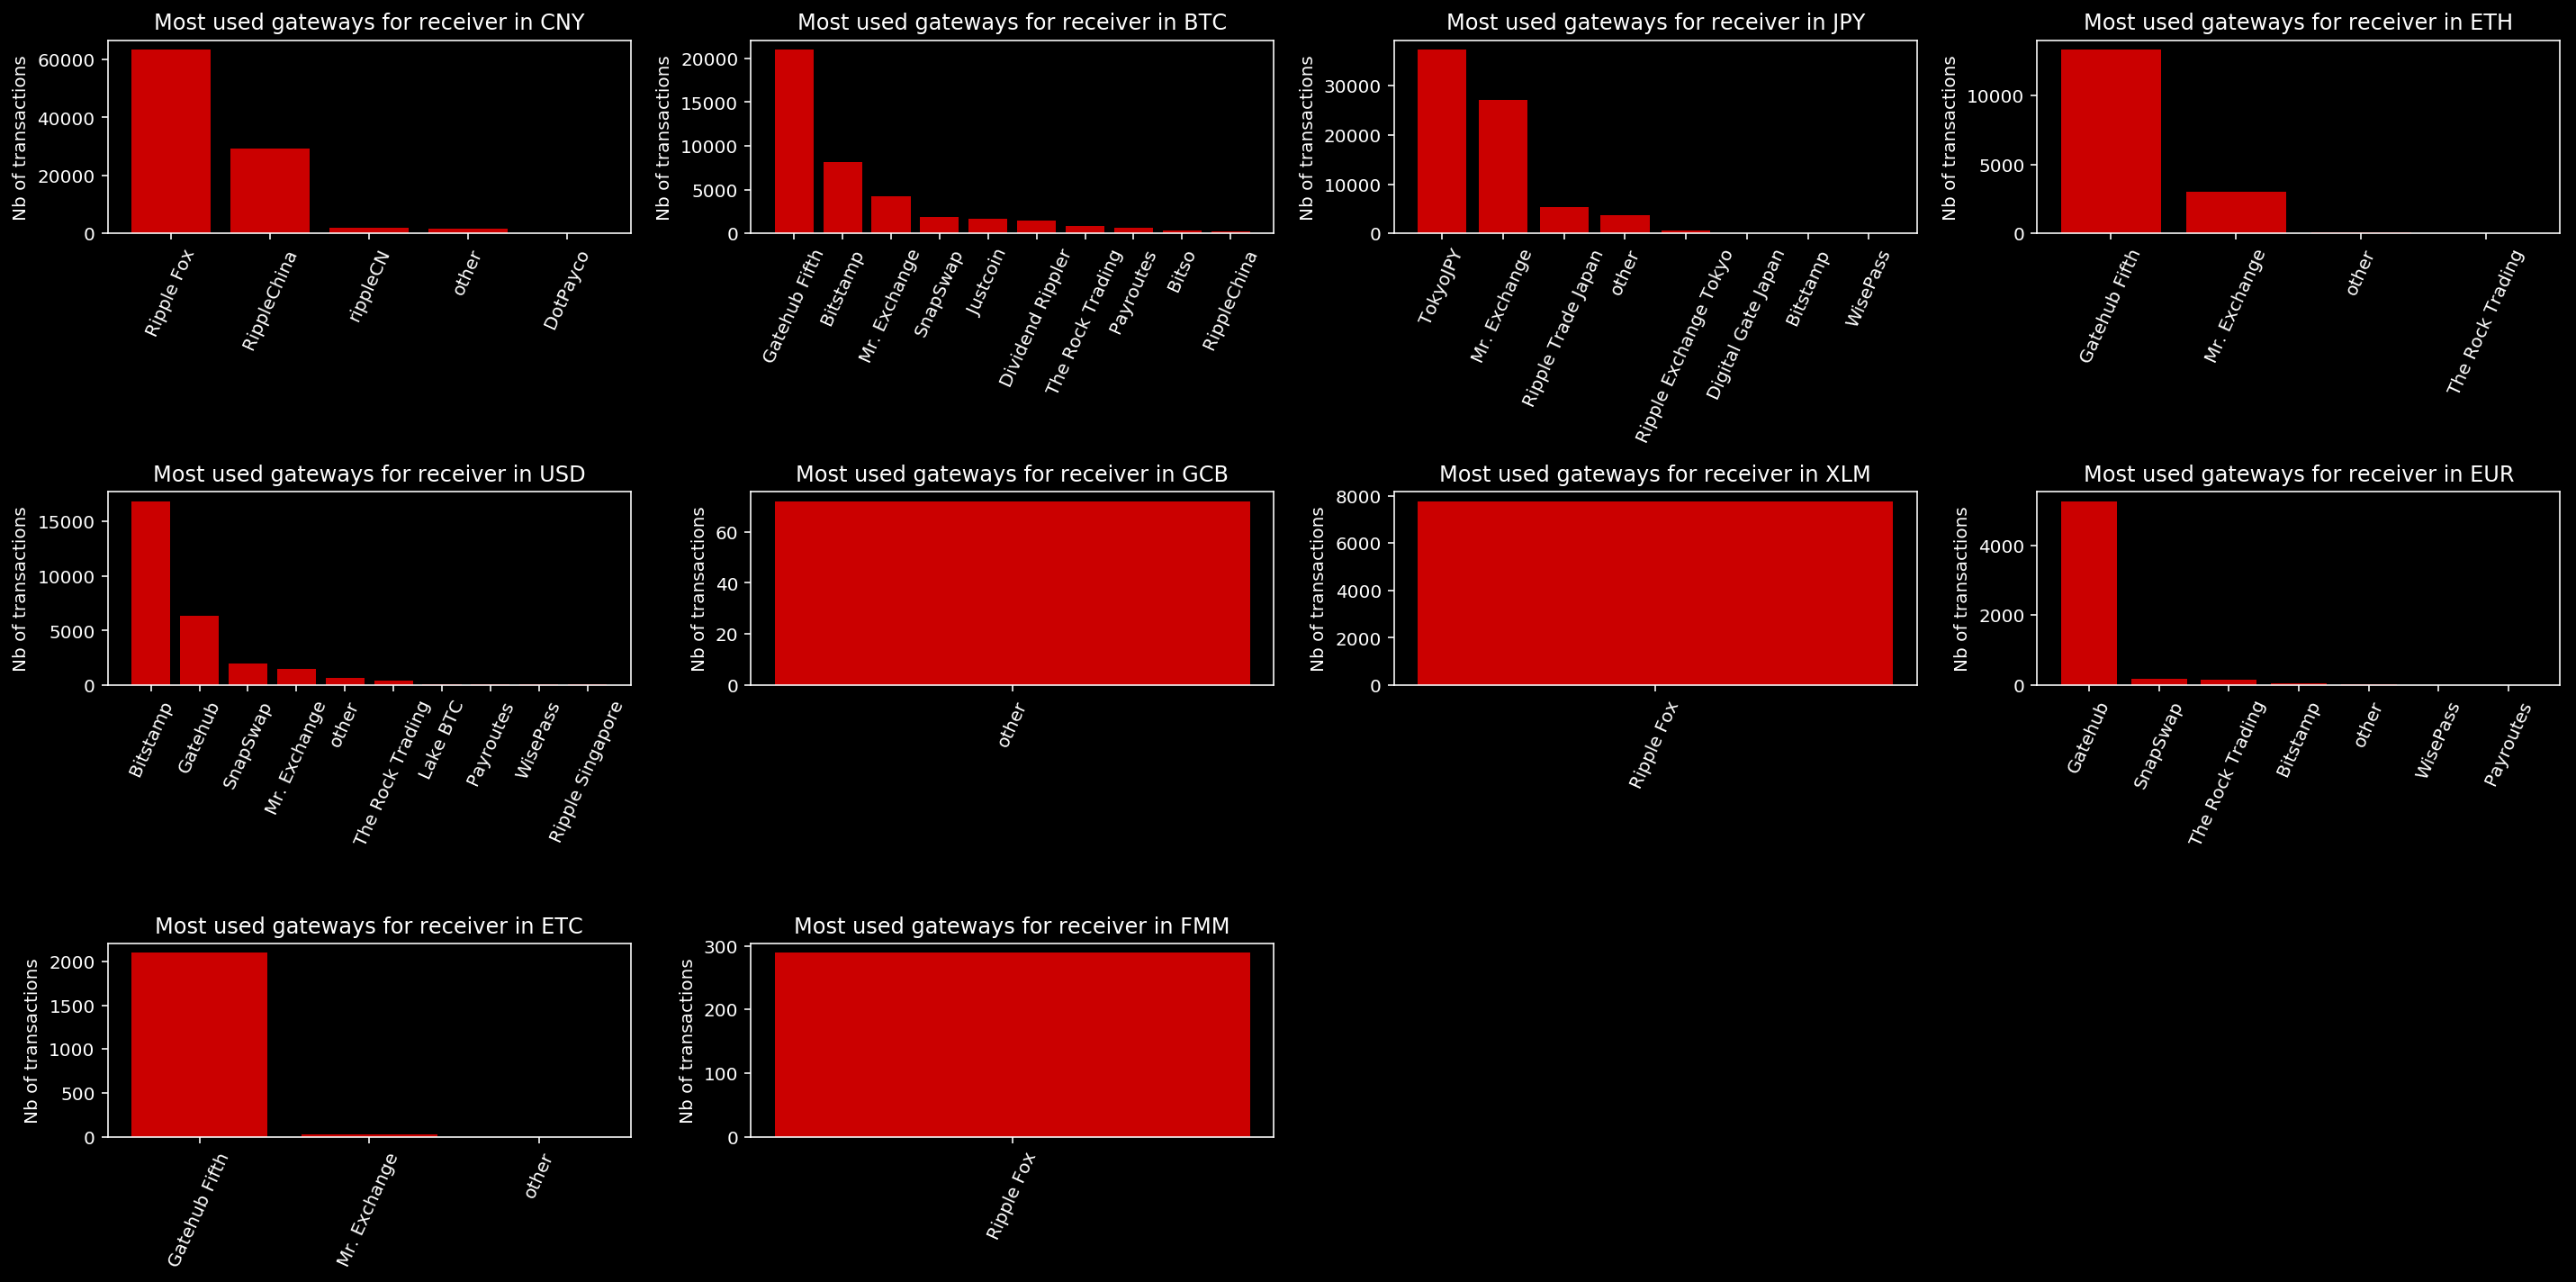

In [342]:
index = 0
for receiver_currency in list(sorted_receiver_currency_volume.keys()): #top 10 currencies of receiver
    if (receiver_currency in receiver_usage_of_trust_lines.keys()) and (index < nb_of_top_currencies):
        trust_line_usage = receiver_usage_of_trust_lines[receiver_currency] #get senders_currency count (dict {currency : count})
        index+=1
        objects = list(trust_line_usage.keys())[0:nb_of_top_currencies]
        y_pos = np.arange(len(objects))
        performance = list(trust_line_usage.values())[0:nb_of_top_currencies]
    
        plt.subplot(3,4,index)
        plt.style.use('dark_background')    
    
        plt.bar(y_pos, performance) #bar plot
        plt.xticks(y_pos, objects,rotation = 65.5)
        plt.ylabel('Nb of transactions')
        plt.title('Most used gateways for receiver in ' + receiver_currency)
    
plt.tight_layout()
plt.show()

In [319]:
count_through_gateways = 0
count_others = 0
for account, currencies in tqdm(receiver_usage_of_trust_lines.items()):
    for currency,values in currencies.items():
            if currency == 'other':
                count_others += value
            else:
                count_through_gateways += value

In [320]:
print("For wallets that have trust line with gateways in a given currency, there are in average", count_through_gateways/(count_through_gateways+count_others)*100,'% of payments in that currency made by this wallet via these trust lines with gateways') 

For wallets that have trust line with gateways in a given currency, there are in average 85.21739130434783 % of payments in that currency made by this wallet via these trust lines with gateways


# 4. Gateways

## 4.1 Gateway per currency zone

Our goal here is to find what currencies are covered by gateways and how many gateways can we find by country.

In [1129]:
dict_gateways = api.get_all_gateways()

In [1130]:
print("There are",len(list(dict_gateways.values())),"known gateways.")

There are 34 known gateways.


List of online gateways according to https://wipple.devnull.network/research/gateways.html

In [1131]:
online_gateways = ['SnapSwap','Gatehub Fifth','Bitstamp','Payroutes','WisePass','The Rock Trading','RippleChina','DotPayco','Coinex','Ripple Fox','Lake BTC','Bitso','GBI','Gatehub','EXRP','BPG']

In [1132]:
currency_to_nb_gateways = {}
for currency, gateways in tqdm(dict_gateways.items()):
    for gateway in gateways:
        if gateway['name'] in online_gateways:
            currency_to_nb_gateways[currency] = currency_to_nb_gateways.get(currency,0) + 1

In [1133]:
country_to_nb_gateways= {}
for currency, nb_gateways in tqdm(currency_to_nb_gateways.items()):
    #Try to convert currency to country (only works if currency is real, ex: BTC will fail)
    try:
        currency = ccy.country(ccy.currency(currency).default_country)
        country_to_nb_gateways[currency] = nb_gateways
    except :
        continue

In [1134]:
country_to_nb_gateways

{'Australia': 2,
 'Switzerland': 1,
 'Eurozone': 4,
 'Britain (UK)': 3,
 'Japan': 2,
 'United States': 8,
 'China': 3,
 'Israel': 1,
 'Norway': 1,
 'Sweden': 1,
 'Mexico': 1,
 'New Zealand': 1,
 'Korea (South)': 1}

# 5. Nodes

In [6]:
nodes = api.get_topology()['nodes']

In [7]:
def get_country_code(ip):
    with urllib.request.urlopen("https://geoip-db.com/jsonp/"+ip) as url:
        answer = url.read().decode()[9:-1] #remove first 9 char and the last of answer to be read to convert to dict
        answer = json.loads(answer)
        return answer['country_name']

In [8]:
count = {}
for node in tqdm(nodes):
    if 'ip' in node.keys():
        country = get_country_code(node['ip'])
        count[country] = count.get(country,0) + 1

In [9]:
del count[None]

In [10]:
count = collections.OrderedDict(sorted(count.items(),key=operator.itemgetter(1),reverse = False))

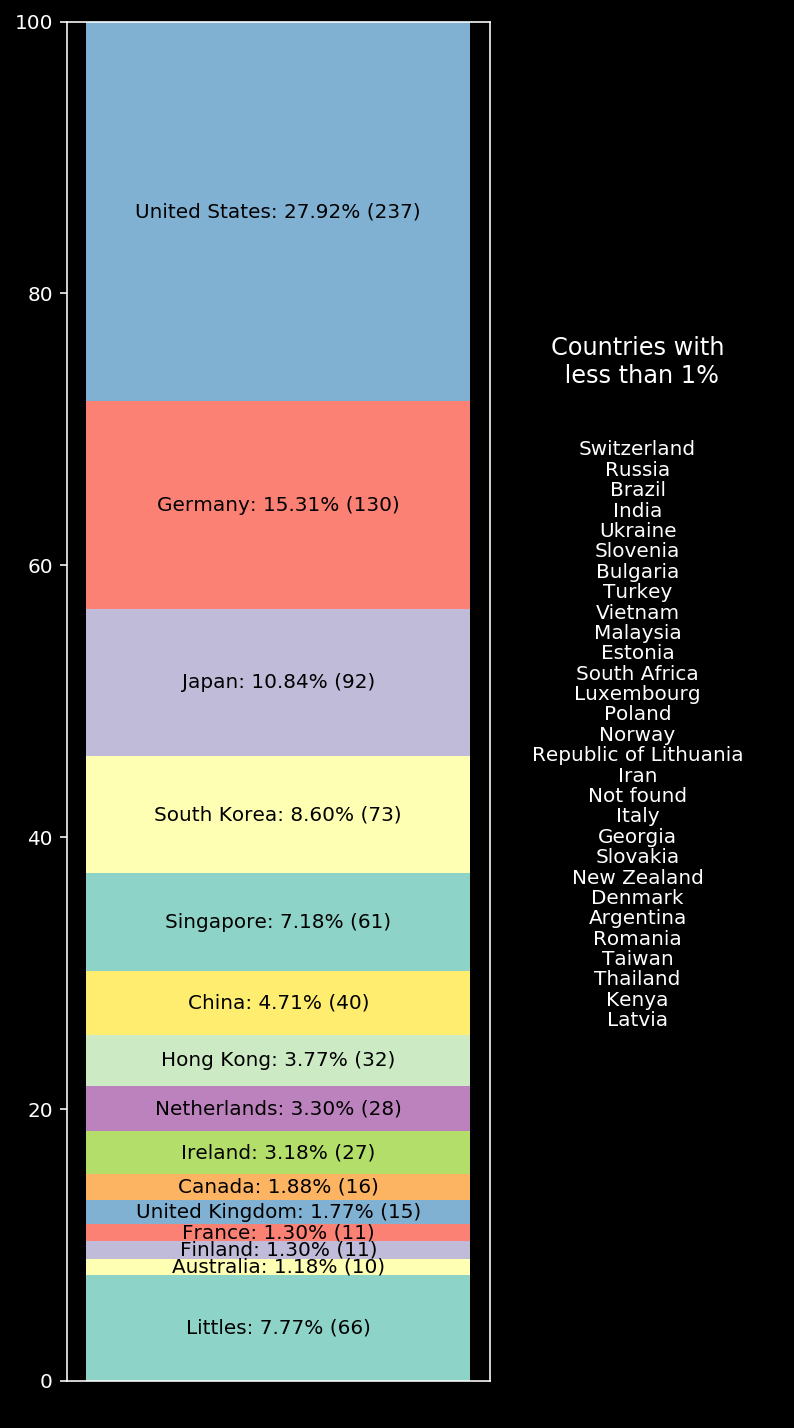

In [37]:
fig, axs = plt.subplots(1,2,figsize = (6.25,12.5),gridspec_kw={'width_ratios': [2, 1]})

total = sum(list(count.values()))
bars_previous=0
littles = 0
littles_names = []
ploted_littles = False

for k,v in tqdm(count.items()):
    bars = v/total*100
    
    if(bars < 1):
        littles+= bars
        littles_names.append(k)
   
    else:
        if(not ploted_littles):
            ploted_littles = True
            axs[0].bar(0,littles)
            axs[0].text(0,0.5*littles,'Littles: %1.2f' %littles+'% '+'(%1.0f' %(littles/100*total)+')',horizontalalignment='center',verticalalignment='center',color='black')
        axs[0].bar(0,bars,bottom = bars_previous)
        axs[0].text(0,bars_previous+0.5*bars,k+": %1.2f"% bars+'% '+'('+str(v)+')',horizontalalignment='center',verticalalignment='center',color='black')
        
    bars_previous+= bars

axs[0].set_ylim(0, 100)
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1].axis('off')
axs[1].text(0.4,0.75, 'Countries with\n less than 1%', horizontalalignment='center',verticalalignment='center',fontsize='large')
i=0
for country in littles_names:
    i+=0.015
    littles_names
    axs[1].text(0.4,0.25+i, country, horizontalalignment='center',verticalalignment='center')

plt.style.use('dark_background')
plt.savefig('Repartiton of nodes.png')
plt.show()